In [1]:
import pandas as pd
from glob import glob
import os
from shutil import copyfile
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from numpy.random import permutation
import matplotlib.pyplot as plt

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18,resnet34
from torchvision.models.inception import inception_v3
from torchvision.models import densenet121
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


%matplotlib inline


In [2]:
is_cuda = torch.cuda.is_available()
is_cuda

True

## Utility functions

In [3]:
def imshow(inp,cmap=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp,cmap)
    
class FeaturesDataset(Dataset):
    
    def __init__(self,featlst,labellst):
        self.featlst = featlst
        self.labellst = labellst
        
    def __getitem__(self,index):
        return (self.featlst[index],self.labellst[index])
    
    def __len__(self):
        return len(self.labellst)
    
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output,target)
        
        running_loss += F.cross_entropy(output,target,size_average=False).data[0]
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

## Creating PyTorch datasets

In [4]:
data_transform = transforms.Compose([
        transforms.Resize((299,299)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


In [5]:
# For Dogs & Cats dataset
train_dset = ImageFolder('../../chapter5/dogsandcats/train/',transform=data_transform)
val_dset = ImageFolder('../../chapter5/dogsandcats/valid/',transform=data_transform)
classes=2

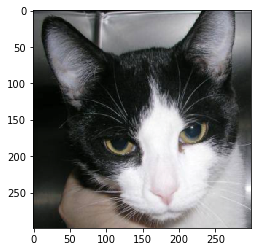

In [6]:
imshow(train_dset[150][0])

## Creating data loader for training and validation datasets

In [7]:
train_loader = DataLoader(train_dset,batch_size=32,shuffle=False,num_workers=3)
val_loader = DataLoader(val_dset,batch_size=32,shuffle=False,num_workers=3)

## Creating Densenet 121 model

In [8]:
my_densenet = densenet121(pretrained=True).features
if is_cuda:
    my_densenet = my_densenet.cuda()

for p in my_densenet.parameters():
    p.requires_grad = False

## Extracting Convolutional features

In [11]:
#For training data
trn_labels = []
trn_features = []

#code to store densenet features for train dataset.
for d,la in train_loader:
    o = my_densenet(Variable(d.cuda()))
    o = o.view(o.size(0),-1)
    trn_labels.extend(la)
    trn_features.extend(o.cpu().data)

#For validation data
val_labels = []
val_features = []

#Code to store densenet features for validation dataset. 
for d,la in val_loader:
    o = my_densenet(Variable(d.cuda()))
    o = o.view(o.size(0),-1)
    val_labels.extend(la)
    val_features.extend(o.cpu().data)

## Creating train and validation feature dataset

In [13]:
# Create dataset for train and validation convolution features
trn_feat_dset = FeaturesDataset(trn_features,trn_labels)
val_feat_dset = FeaturesDataset(val_features,val_labels)

# Create data loaders for batching the train and validation datasets
trn_feat_loader = DataLoader(trn_feat_dset,batch_size=64,shuffle=True,drop_last=True)
val_feat_loader = DataLoader(val_feat_dset,batch_size=64)

## A Fully connected network

In [14]:
class FullyConnectedModel(nn.Module):
    
    def __init__(self,in_size,out_size):
        super().__init__()
        self.fc = nn.Linear(in_size,out_size)

    def forward(self,inp):
        out = self.fc(inp)
        return out

In [16]:
trn_features[0].size(0)

82944

In [17]:
fc_in_size = trn_features[0].size(0)

In [18]:
fc = FullyConnectedModel(fc_in_size,classes)
if is_cuda:
    fc = fc.cuda()

In [19]:
optimizer = optim.Adam(fc.parameters(),lr=0.0001)

## Train and validate the model

In [20]:

train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,fc,trn_feat_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,fc,val_feat_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is 0.057 and training accuracy is 22506/23000     97.85
validation loss is 0.034 and validation accuracy is 1978/2000      98.9
training loss is 0.0059 and training accuracy is 22953/23000      99.8
validation loss is 0.028 and validation accuracy is 1981/2000     99.05
training loss is 0.0016 and training accuracy is 22974/23000     99.89
validation loss is 0.022 and validation accuracy is 1983/2000     99.15
training loss is 0.00064 and training accuracy is 22976/23000      99.9
validation loss is 0.023 and validation accuracy is 1983/2000     99.15
training loss is 0.00043 and training accuracy is 22976/23000      99.9
validation loss is 0.024 and validation accuracy is 1983/2000     99.15
training loss is 0.00033 and training accuracy is 22976/23000      99.9
validation loss is 0.024 and validation accuracy is 1984/2000      99.2
training loss is 0.00025 and training accuracy is 22976/23000      99.9
validation loss is 0.024 and validation accuracy is 1984/2000      9